In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

%matplotlib notebook

In [5]:
%matplotlib notebook

In [6]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


In [7]:
#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


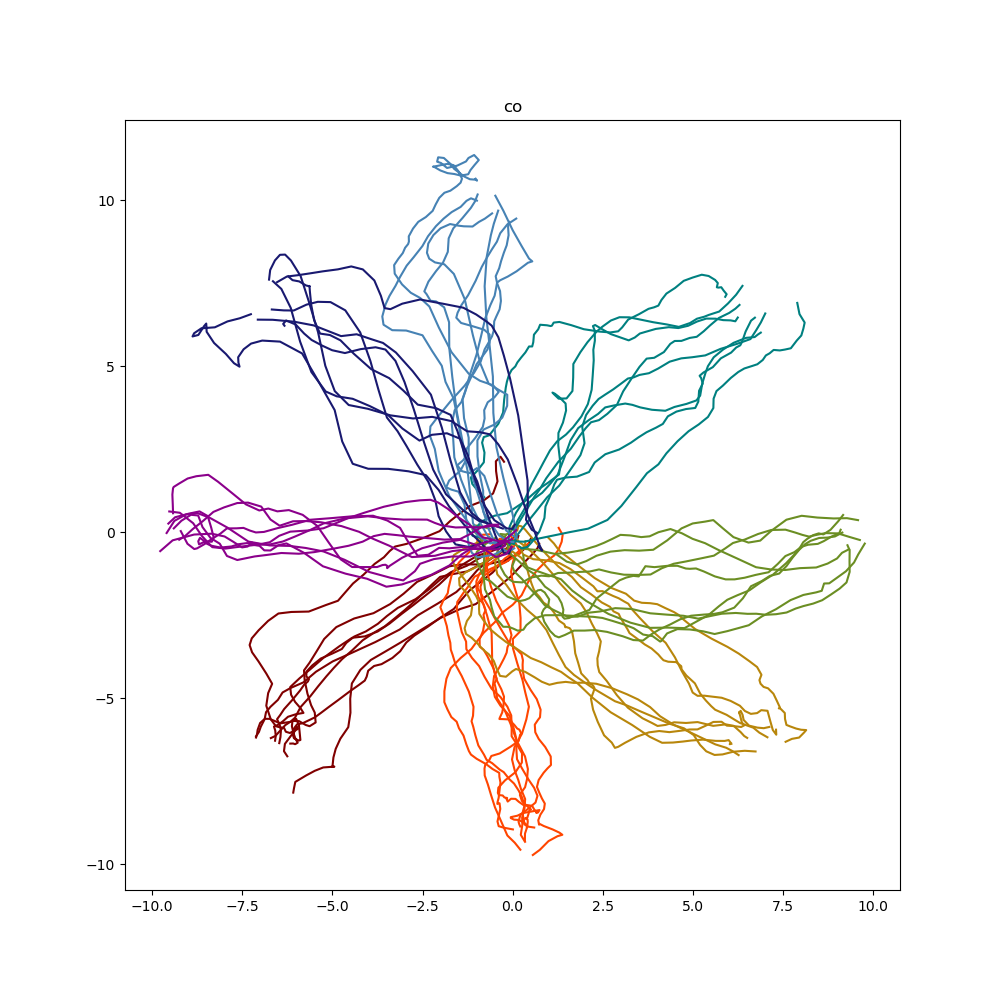

<IPython.core.display.Javascript object>


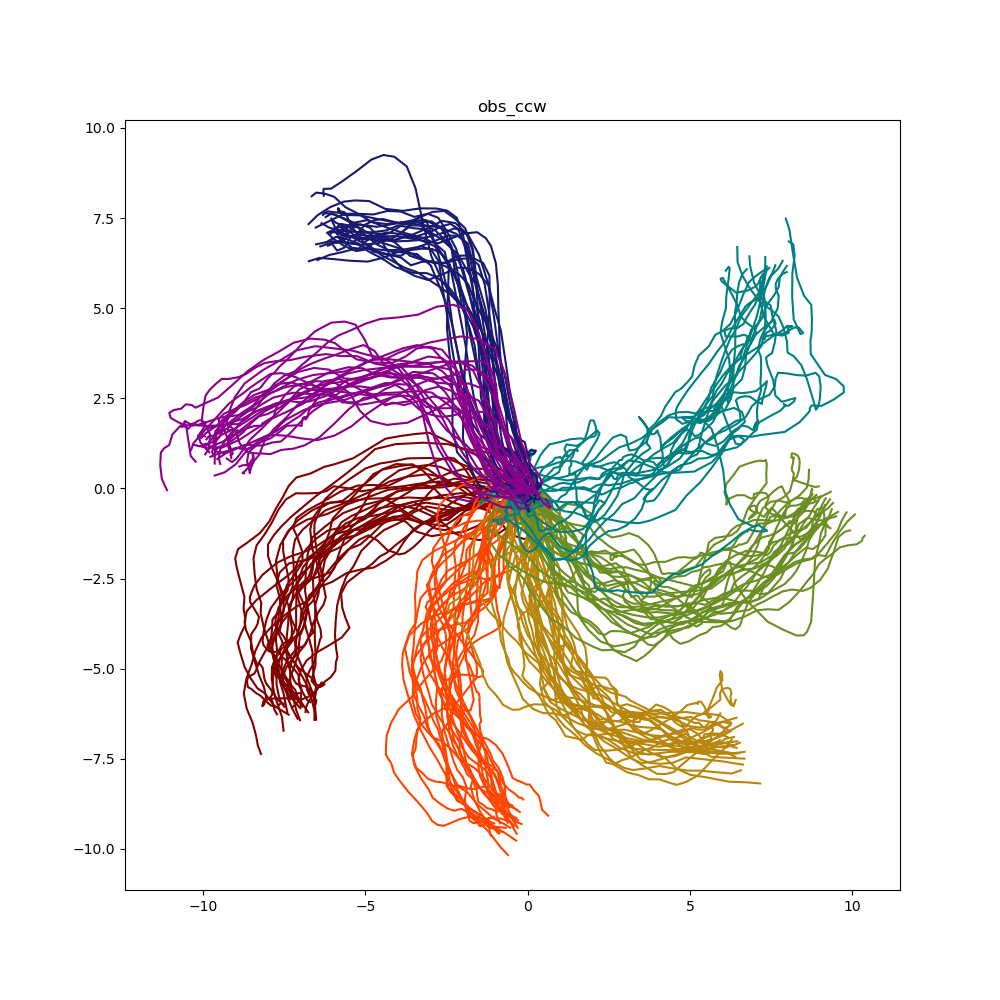

<IPython.core.display.Javascript object>


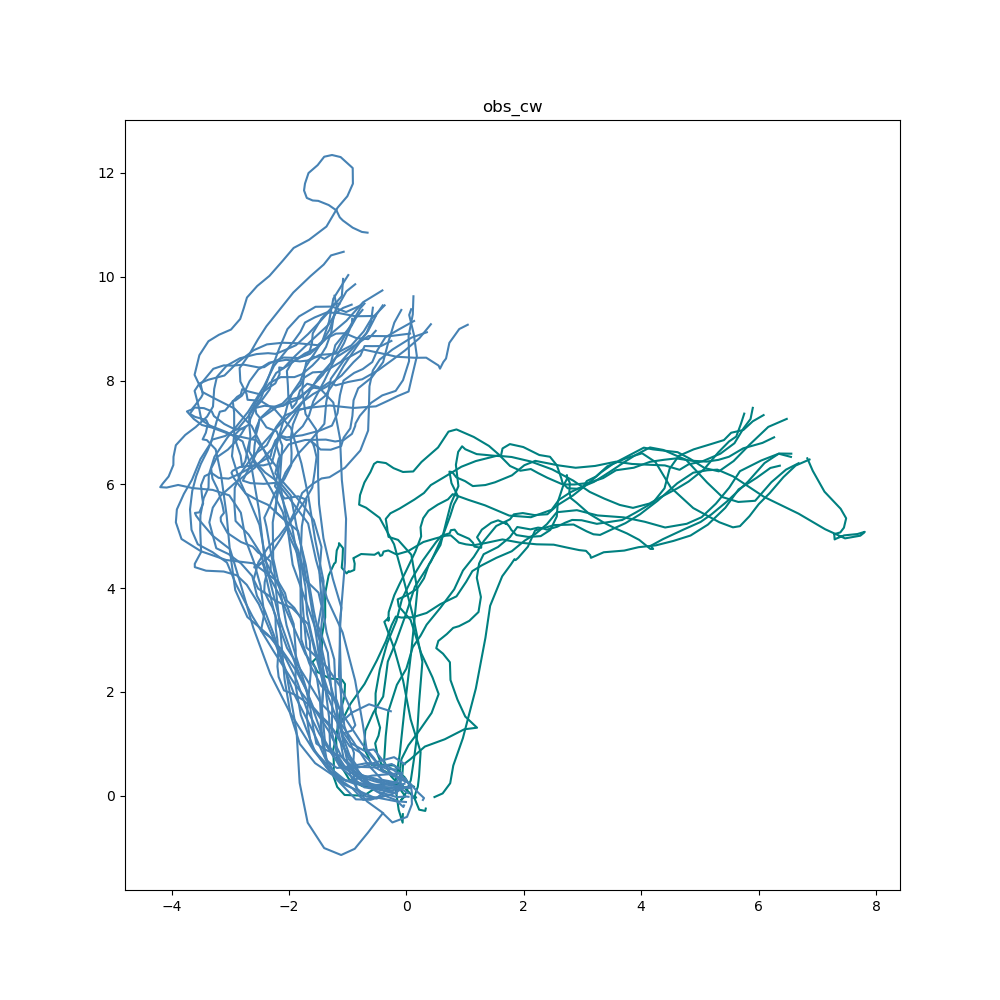

In [8]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

In [9]:
mag_bin_edges

array([[0.01594599, 0.8449011 , 1.32171331, 1.85882319, 3.2226475 ],
       [0.8449011 , 1.32171331, 1.85882319, 3.2226475 , 7.01433267]])

<IPython.core.display.Javascript object>


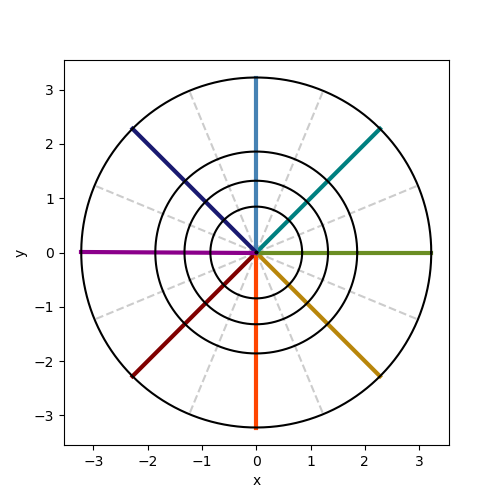

In [10]:
num_mag_bins_analyze=4
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges[:,:(num_mag_bins_analyze)], target_color)
    
plt.figure(figsize=(5,5))
plot_command_bin()    

### Plot an example trial

4704     115.0
4755     116.0
4796     117.0
4842     118.0
4890     119.0
4941     120.0
4988     121.0
5046     122.0
5122     123.0
5392     127.0
10206    238.0
Name: trial_global, dtype: float64


<IPython.core.display.Javascript object>


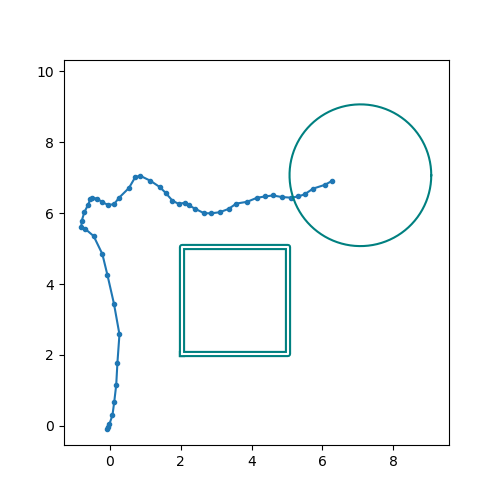

(-1.3012247717787875,
 9.564986506324725,
 -0.5427594616898825,
 10.32345181641363)

In [11]:
target = 4
sel_target = (df['target']==target)
sel_start = (df['bin']==0)
sel_task = (df['task_rot']==1.2) #1.2 is clockwise, 1.1 is counterclockwise
sel = sel_target&sel_start&sel_task
trials = df.loc[sel,'trial_global']
print(trials)

trial = int(trials.iloc[0])
sel_trial = (df['trial_global']==trial)
sel_bin = (df['bin']>=0)
sel = sel_trial&sel_bin

x = df.loc[sel, 'kin_px']
y = df.loc[sel, 'kin_py']

plt.figure(figsize=(5,5))
plt.plot(x,y, '.-')
c = target_color[target]
bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))
bmi_util.plot_targets(target_pos[target,:].reshape((1,-1)), [c], target_r_task[1]*np.ones(1))
plt.axis('square')

### Neural dynamics 

In [12]:
n_list = ['n_'+ str(i) for i in np.arange(num_neurons)]

sel_t_bin = (df['bin'] >= 0)
sel_t_bin_end = (df['bin_end'] >= 1)
sel_t = (sel_t_bin)&(sel_t_bin_end)
n_t = df.loc[sel_t,n_list]

sel_tp1_bin = (df['bin'] >= 1)
sel_tp1_bin_end = (df['bin_end'] >= 0)
sel_tp1 = (sel_tp1_bin)&(sel_tp1_bin_end)
n_tp1 = df.loc[sel_tp1,n_list]

# regression: 
#ridge parameter from Preeya: 2500
clf = Ridge(alpha=2500)
clf.fit(np.array(n_t), np.array(n_tp1))

An = clf.coef_
bn = clf.intercept_

#Put into numpy matrices
An_m = np.mat(An)
bn_m = np.mat(bn).T

n_t_m = np.mat(n_t).T
n_tp1_m = np.mat(n_tp1).T
nhat_tp1 = An_m*n_t_m+bn_m

#sanity check we can use the dynamics parameters:
total_cov = np.cov(n_tp1_m)
total_var = np.trace(total_cov)

res_hat = nhat_tp1-n_tp1_m #44 x num_obs
res_cov = np.cov(res_hat) #44 x 44
res_var = np.trace(res_cov)

pred_cov = np.cov(nhat_tp1)
pred_var = np.trace(pred_cov)

print('sanity check on neural dynamics fit:')
print('viveks test R2: ', 1-res_var/total_var)
print('true R2: ', clf.score(n_t, n_tp1))

#Calculate mean activity for all neurons @ bin=0 to initialize future simulations: 
sel_bin = (df['bin'] == 0)
n_init = df.loc[sel_bin, n_list].mean()

sanity check on neural dynamics fit:
('viveks test R2: ', 0.24517725254512746)
('true R2: ', 0.2451772525451282)


### Form matrices

In [13]:
kin_var = ['kin_px', 'kin_py', 'kin_vx', 'kin_vy']
num_kin = len(kin_var)
offset_var = ['offset']
num_offset = len(offset_var)

#F: 5x5
sel_F = np.array([0,2,3,5,6])
F = decoder['F'][sel_F, :]
F = F[:,sel_F]
print(F.shape)
F = xr.DataArray(F, coords={'out':kin_var+offset_var, 'in':kin_var+offset_var}, dims=['out', 'in'])

#K: 5xnum_neurons
sel_K = np.array([0,2,3,5,6])
Kn = decoder['K'][sel_K, :] #decoder mapping neural to control

(5L, 5L)


In [14]:
#DEFINE DYNAMICS:
A_list, A_dic, B = bmi_b.def_nk_AB(An_m, bn_m, Kn, F, num_neurons, num_kin)
state_dim = num_neurons+num_kin+1
state_label = n_list+kin_var+offset_var

In [15]:
#Define QR:
Qfp_s = 1e7
Qfv_s = Qfp_s
Qp_s = 0
Qv_s = 0
R_s = 1

Q_f, Q, R = bmi_b.def_nk_QR(Qfp_s, Qfv_s, Qp_s, Qv_s, R_s, state_label, state_dim, num_neurons, num_kin, n_list, kin_var, offset_var)

In [16]:
#Define Models for each movement
#For each movement:
#Define number of segments, number of 

move_horizon = 39
model_list = ['n_do', 'n_o', 'n_null']
input_label = n_list

target_list = range(num_targets)
task_rot_list = [0,1.1,1.2]
center = np.array([0,0])
#waypoint parameters:
obs_margin = 6
waypoint_speed = 10

#This does movement simulation too!  
n_init_sel = n_init #np.zeros(len(n_init)) #n_init

move_lqr = bmi_b.def_move_models(\
    move_horizon, model_list, A_dic, B, Q, R, Q_f,\
    target_list, task_rot_list, center, target_pos, obs_pos, n_init_sel, obs_margin, waypoint_speed,\
    state_label, state_dim, input_label, num_neurons, hold_req=2, target_r=1.7)

In [17]:
#Collect norm_u results: 
columns = ['norm_u', 'target', 'task', 'model']
num_col = len(columns)
nan_df = pd.DataFrame(np.ones((1,num_col))*np.nan, columns=columns)
df_list = []
for target in target_list:
    for task in task_rot_list:
        for m in model_list:
            df_i = copy.deepcopy(nan_df)
            df_i['norm_u'] = np.linalg.norm(move_lqr[target,task,m]['u_da'])
            df_i['target'] = target
            df_i['task'] = task
            df_i['model'] = m
            
            df_list.append(df_i)
lqr_df = pd.concat(df_list, ignore_index=True)

<IPython.core.display.Javascript object>


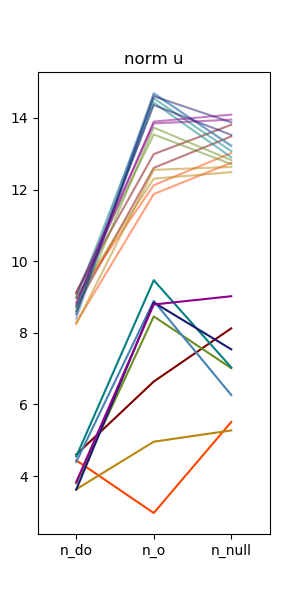

(-0.5, 2.5)

In [18]:
#Plot norm u for all movements: 
model_list = ['n_do', 'n_o', 'n_null']
# model_list = ['n_do', 'n_null']
task_alpha = {0:1, 1.1:0.5, 1.2:0.5}
plt.figure(figsize=(3,6))
for target in target_list:
    for task in task_rot_list:
        
        x_plot = []
        y_plot = []
        for i,m in enumerate(model_list):
            x_plot.append(i)
            sel = \
            (lqr_df['target']==target)\
            &(lqr_df['task']==task)\
            &(lqr_df['model']==m)
            y_i = float(lqr_df.loc[sel,'norm_u'])
            y_plot.append(y_i)
            
        plt.plot(x_plot,y_plot,color=target_color[target], alpha=task_alpha[task]) #label='target'+str(target)+'task'+str(task)

plt.xticks(range(len(model_list)), model_list)
plt.ylabel('norm u')
plt.title('norm u')
plt.xlim([-0.5,2.5])

<IPython.core.display.Javascript object>


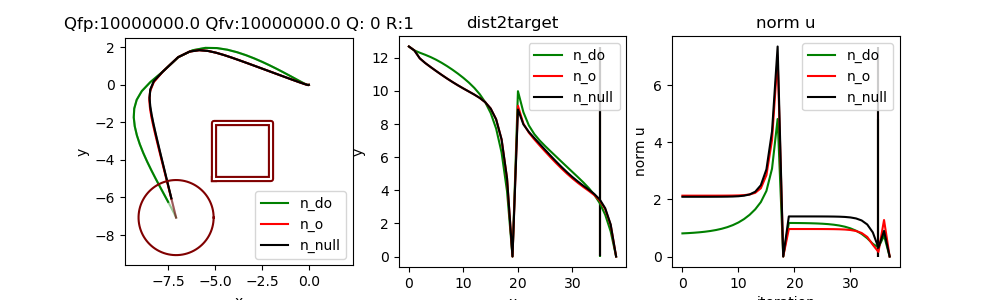

In [82]:
#Show diagnostics for the example: 

#Plot each on the same subplot
#Visualize results: 
target = 0
task = 1.1 #1.2
horizon_list = move_lqr[target,task,'n_do']['horizon_list']


#hardcoded:
if task >0:
    num_seg = 2
else:
    num_seg = 1    
if task == 0: 
    seg_x = np.array([[0], [horizon_list[0]]])
else:
    seg_x = np.array([[0, horizon_list[0]], [horizon_list[0]-1, sum(horizon_list)-2]])

state_T_list = move_lqr[target,task,m]['state_T_list']
state_T_mat = np.array(state_T_list).squeeze().T
if task==0:
    state_T_mat = state_T_mat.reshape((-1,1))
state_T_da = xr.DataArray(state_T_mat, coords={'v':n_list+kin_var+offset_var, 'seg':range(num_seg)},\
                           dims=['v', 'seg'])    
    


model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}

model_list = ['n_do', 'n_o', 'n_null']
plt.figure(figsize=(10,3))
#------------------------------------------------------------------
#CURSOR PLOTS:
plt.subplot(1,3,1)
for i,m in enumerate(model_list): #enumerate(task_models[task]):
    state_da = move_lqr[target,task,m]['state_da']
    sim_len = move_lqr[target,task,m]['sim_len']
    
    
    x = state_da.loc['kin_px',:]
    y = state_da.loc['kin_py',:]        
    plt.plot(x,y,'-', alpha=0.4, color=model_color[m]) # label=k
    
    x = state_da.loc['kin_px',np.arange(0,sim_len)]
    y = state_da.loc['kin_py',np.arange(0,sim_len)]
    plt.plot(x,y,'-', label=m, color=model_color[m])

bmi_util.plot_targets(target_pos[target:target+1,:], target_color[target:target+1], target_r_task[1]*np.ones(1)) 
c = target_color[target]
bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))
plt.axis('square')    
plt.xlabel('x')
plt.ylabel('y')
plt.title(m)
plt.legend()
plt.title('Qfp:' + str(Qfp_s) + ' Qfv:' + str(Qfv_s) + ' Q: ' + str(Qp_s) + ' R:' + str(R_s))  

#------------------------------------------------------------------
#Dist2Target PLOTS:
#Let's modify this to subtract the segment's goal, to verify targets are being met.

    
plt.subplot(1,3,2)
for i,m in enumerate(model_list): #for i,m in enumerate(task_models[task]):       
#     e_da = move_lqr[target,task,m]['state_e_da'].loc[['kin_px', 'kin_py'],:]
    e_a = \
        move_lqr[target,task,m]['state_da'].loc[kin_var,:]
    for seg in range(num_seg):
        e_a.loc[:,seg_x[0,seg]:seg_x[1,seg]] = e_a.loc[:,seg_x[0,seg]:seg_x[1,seg]] - \
            state_T_da.loc[kin_var,seg]
    norm_e_a = np.linalg.norm(e_a,axis=0)
    
    sim_len = move_lqr[target,task,m]['sim_len']
    norm_e = np.linalg.norm(e_a,axis=0)
    plt.plot(norm_e_a,'-',label=m, color=model_color[m])
    plt.vlines(sim_len, norm_e_a.min(), norm_e_a.max(), color=model_color[m]) #label=k+' done!'

plt.xlabel('x')
plt.ylabel('y')
plt.title(m)
plt.legend()
plt.title('dist2target')     

#------------------------------------------------------------------
#INPUT PLOTS:
plt.subplot(1,3,3)
# for i,m in enumerate(task_models[task]):
for i,m in enumerate(model_list):    
    u_da = move_lqr[target,task,m]['u_da']    
    sim_len = move_lqr[target,task,m]['sim_len']
    norm_u = np.linalg.norm(u_da,axis=0)
    plt.plot(norm_u,'-',label=m, color=model_color[m])
    plt.vlines(sim_len, norm_u.min(), norm_u.max(), color=model_color[m]) #label=k+' done!'
plt.xlabel('iteration')
plt.ylabel('norm u')
plt.title('norm u')
plt.legend()



### Check waypoint neural

In [138]:
target = 0
task = 1.1
m = 'n_do'
state_da = move_lqr[target,task,m]['state_da']

In [139]:
move_lqr[target,task,m].keys()

['A',
 'Q_f',
 'sim_len',
 'B',
 'K_list',
 'move_len',
 'u_da',
 'Q',
 'state_e_da',
 'R',
 'state_T_list',
 'state_init',
 'state_da',
 'horizon_list',
 'A_e_list']

In [140]:
state_da.shape

(49L, 39L)

In [141]:
move_lqr[target,task,m]['state_T_list'][0]

matrix([[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0

In [143]:
state_da.loc[:,19]

<xarray.DataArray (v: 49)>
array([ 1.336640e+00,  5.388042e-01,  2.698975e-02,  2.902627e-02,
        1.673432e+00,  2.855041e+00,  1.634103e+00,  3.129059e-01,
        2.285845e-02,  1.793899e-02,  7.090880e-03,  1.946769e+00,
        5.729493e-02,  1.875629e-02,  1.489727e+00,  2.174612e+00,
        6.749830e-01,  8.255629e-01,  1.442313e+00,  6.269399e-01,
        5.577932e-01,  1.578833e+00,  1.852158e+00,  1.883985e+00,
        4.709906e-01,  6.479736e-01,  1.514552e+00,  2.178650e+00,
        1.098048e+00,  7.577740e-01,  1.328782e+00,  2.164262e+00,
        1.945470e+00,  1.087015e+00,  5.450806e-01,  1.533726e+00,
        1.258891e+00,  1.121458e+00,  1.621356e+00,  2.011374e+00,
       -1.169009e-01,  7.330237e+00,  1.665064e+00,  1.053457e+00,
       -7.778174e+00,  7.071067e-01, -7.071068e+00, -7.071067e+00,
        1.000000e+00])
Coordinates:
    obs      int32 19
  * v        (v) |S6 'n_0' 'n_1' 'n_2' 'n_3' ... 'kin_vx' 'kin_vy' 'offset'

In [125]:
np.linalg.norm(state_da.loc[n_list,18])

13.139840284338456

In [144]:
np.linalg.norm(state_da.loc[n_list,19])

11.428382932314793

In [130]:
np.linalg.norm(state_da.loc[n_list,0])

8.274685474187558

### Collect the movements into a results df

In [20]:
u_list = ['u_' + str(i) for i in range(num_neurons)]
decode_var = ['u_px', 'u_py', 'u_vx', 'u_vy', 'u_offset']
Kn_m = np.mat(Kn)

target = 2
task = 1.1 
m = 'n_null'
move_len = move_lqr[target,task,m]['move_len']

df_list = []

lqr_var = ['model']
task_var = ['task_rot', 'target', 'bin', 'bin_end', 'trial']
lqr_df_var = n_list+kin_var+decode_var+u_list+task_var+lqr_var
num_col = len(lqr_df_var)


for target in target_list:
    for task in task_rot_list:
        for m in model_list:

            #n_list, kin_var:
            state_da = move_lqr[target,task,m]['state_da']
            #input:
            u_da = xr.DataArray(np.zeros((num_neurons,move_len)), coords={'v':u_list, 'obs':range(move_len)}, dims=['v', 'obs'])
            u_da.loc[:,0:(move_len-2)]=np.array(move_lqr[target,task,m]['u_da']) #append a zeros to the end of it so it's the same size as state_da
            #decode_var:
            n2k = Kn_m*state_da.loc[n_list,:]
            n2k_da = xr.DataArray(n2k, coords={'v':decode_var, 'obs':range(move_len)}, dims=['v', 'obs'])

            #ASSIGN:
            df_i = pd.DataFrame(pd.DataFrame(np.ones((move_len,num_col))*np.nan, columns=lqr_df_var))
            #n_list, kin_var, decode_var, u_list
            df_i.loc[:,n_list] = state_da.loc[n_list,:].T
            df_i.loc[:,kin_var] = state_da.loc[kin_var,:].T
            df_i.loc[:,decode_var] = n2k_da.T            
            df_i.loc[:,u_list] = u_da.T
            #Task-related data:
            df_i.loc[:,'model'] = m
            df_i.loc[:,'task_rot'] = task
            df_i.loc[:,'target'] = target
            df_i.loc[:,'trial'] = 0
            df_i.loc[:,'bin'] = range(move_len)
            df_i.loc[:,'bin_end'] = range(move_len-1,-1,-1)
            
            df_list.append(df_i)
df_lqr = pd.concat(df_list, ignore_index=True)

In [21]:
#Preprocess: 
#-------------------------------------------------------------------------------------------------
bmi_b.df_bmi_cartesian2polar(df_lqr)
#-------------------------------------------------------------------------------------------------

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8

#-------------------------------------------------------------------------------------------------
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df_lqr, mag_bin_perc, num_angle_bins, T0_angle)
#-------------------------------------------------------------------------------------------------


#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df_lqr, angle_bin)
#Then preprocess to get angles: 
bmi_b.df_bin_command(df_lqr, mag_bin_edges,angle_bin_edges)
# #Center angles to command bin, target: 
bmi_b.center_df_angle(df_lqr, angle_bin_c, target_angle)



('angle_center:', 22.5)
('min centered angle:', -157.45107082006132)
('max centered angle:', 202.3909314930218)


<IPython.core.display.Javascript object>


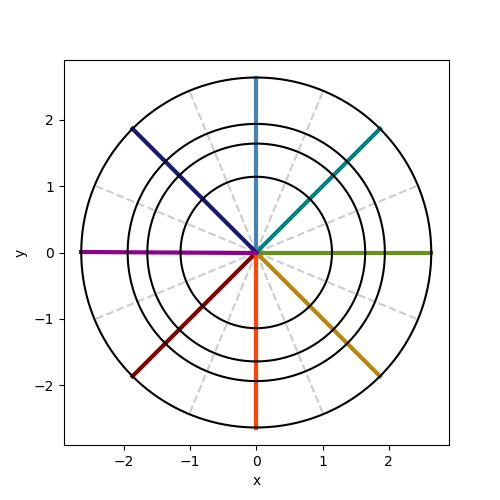

In [22]:
num_mag_bins_analyze=4
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges[:,:(num_mag_bins_analyze)], target_color)
    
plt.figure(figsize=(5,5))
plot_command_bin()    

In [308]:
list(df_lqr.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'u_offset',
 'u_0',
 'u_1',
 'u_2',
 'u_3',
 'u_4',
 'u_5',
 'u_6',
 'u_7',
 'u_8',
 'u_9',
 'u_10',
 'u_11',
 'u_12',
 'u_13',
 'u_14',
 'u_15',
 'u_16',
 'u_17',
 'u_18',
 'u_19',
 'u_20',
 'u_21',
 'u_22',
 'u_23',
 'u_24',
 'u_25',
 'u_26',
 'u_27',
 'u_28',
 'u_29',
 'u_30',
 'u_31',
 'u_32',
 'u_33',
 'u_34',
 'u_35',
 'u_36',
 'u_37',
 'u_38',
 'u_39',
 'u_40',
 'u_41',
 'u_42',
 'u_43',
 'task_rot',
 'target',
 'bin',
 'bin_end',
 'trial',
 'model',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 

<IPython.core.display.Javascript object>


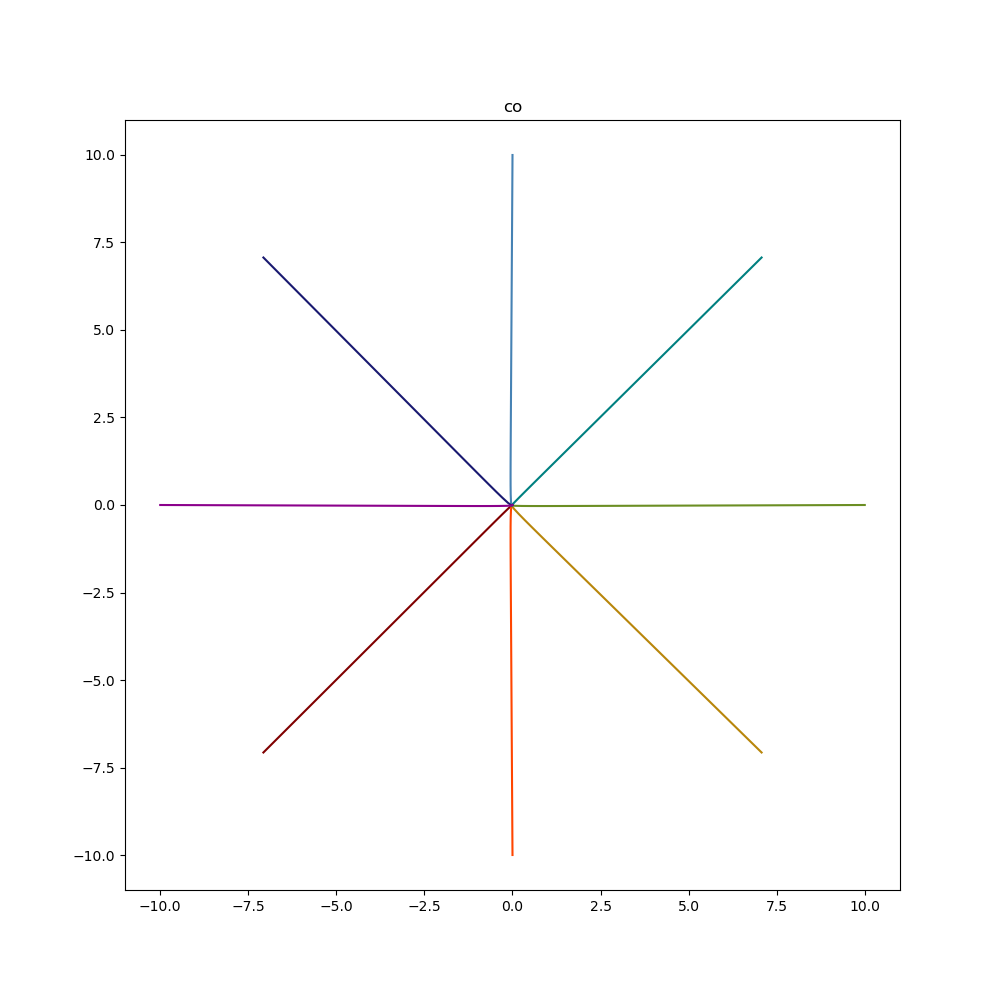

<IPython.core.display.Javascript object>


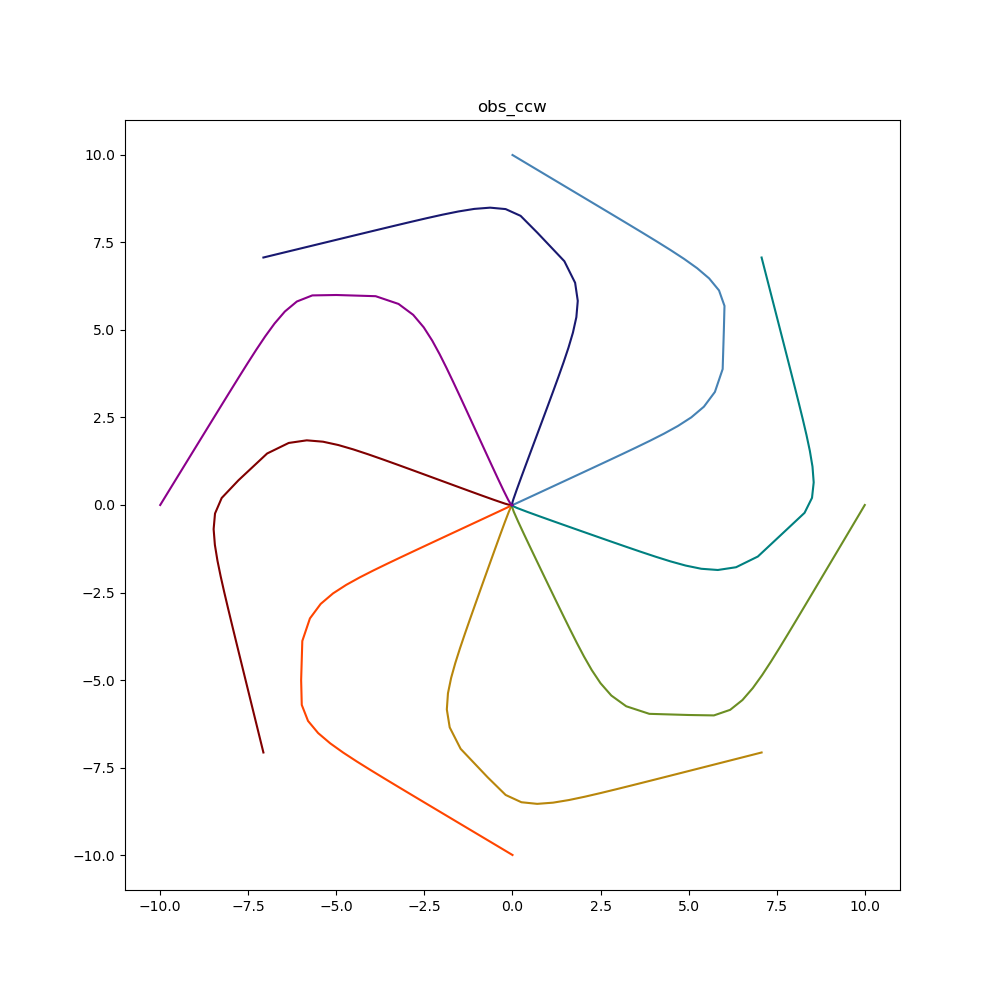

<IPython.core.display.Javascript object>


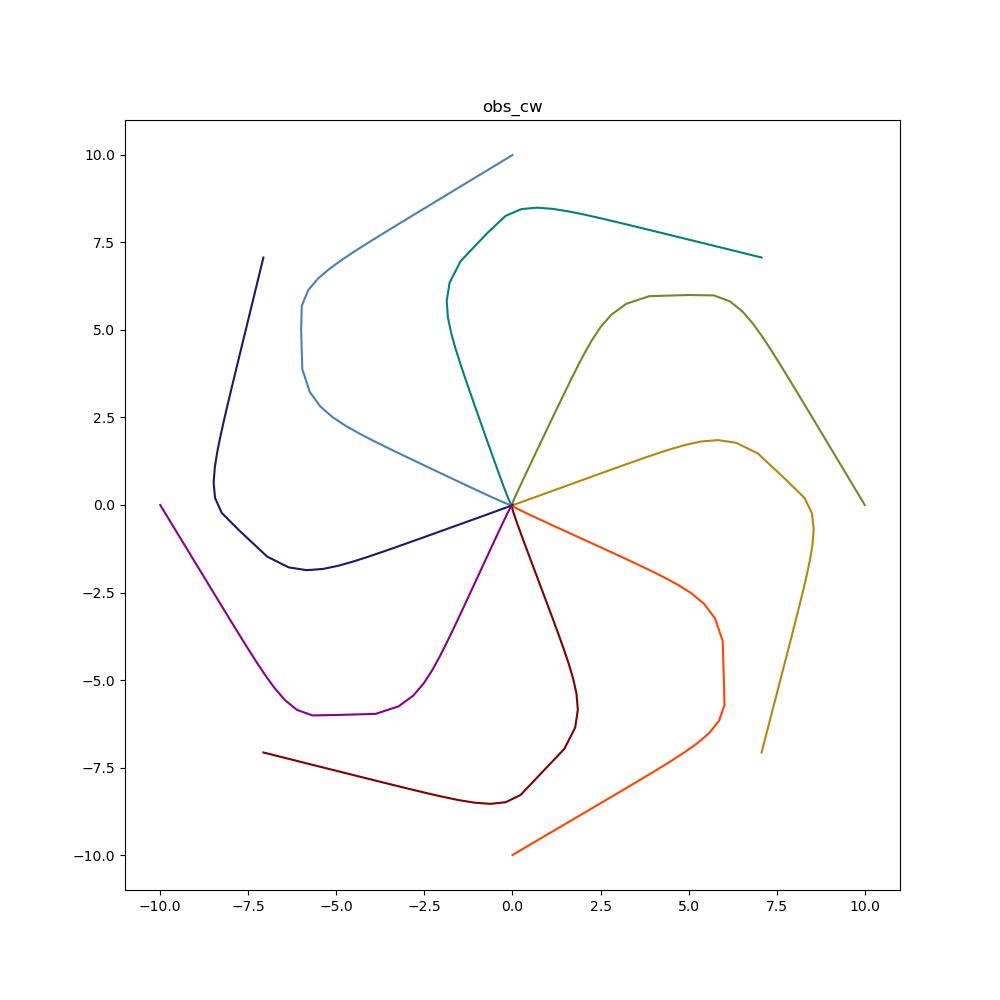

In [24]:
#Plot cw vs ccw trials, to confirm: 
m = 'n_null'
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']


for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])    
    for target in range(num_targets):    
        sel = (df_lqr['task_rot']==task) & (df_lqr['bin']>=0) & (df_lqr['target']==target) & (df_lqr['model'] == m)
        df_sel = df_lqr[sel]
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where(df_sel['bin']==0)[0]
        trial_stop = np.where(df_sel['bin_end']==0)[0]
        trial_bound = np.vstack((trial_start,trial_stop)).T
        #------------------------------------------------------------------------------------
        for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
#             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
            x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
            y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
            color = target_color[target]
            plt.plot(x,y,'-',color=color)

### Analyze the df: 

In [129]:
#Calculate for each bin the average activity: 
#Then ... for each model, calc command_move_mean - move_mean. 
#to start, we ask if pooling already shows a difference.

#command mean: diff, ang, mag, model
df_mean_col = n_list + ['ba', 'bm', 'model', 'num']
nan_df = pd.DataFrame()
df_mean = []

sel_bin = df_lqr['bin']>=2
for ba in range(num_angle_bins):
    sel_ba = (df_lqr['u_v_angle_bin']==ba)
    for bm in range(num_mag_bins_analyze):
        sel_bm = (df_lqr['u_v_mag_bin']==bm)
        for m in model_list:
            sel_m = (df_lqr['model'] == m)
            
            
            sel = sel_ba&sel_bm&sel_m&sel_bin
            n_i = df_lqr.loc[sel,n_list].mean()
            
            
            df_i = pd.DataFrame(pd.DataFrame(np.ones((1,len(df_mean_col)))*np.nan, columns=df_mean_col))
            df_i.loc[0,n_list]=n_i
            df_i['ba'] = ba
            df_i['bm'] = bm
            df_i['model'] = m
            df_i['num'] = len(np.where(sel)[0])
            df_mean.append(df_i)
df_mean = pd.concat(df_mean, ignore_index=True)        

                      

In [134]:
#mean diff: 
df_diff_col = n_list + ['diff', 'ba', 'bm', 'model', 'target', 'task_rot', 'num']
nan_df = pd.DataFrame()
df_diff = []
sel_bin = df_lqr['bin']>=1
for ba in range(num_angle_bins):
    sel_ba = (df_lqr['u_v_angle_bin']==ba)
    sel_d_ba = (df_mean['ba'] == ba)    
    for bm in range(num_mag_bins_analyze):
        sel_bm = (df_lqr['u_v_mag_bin']==bm)
        sel_d_bm = (df_mean['bm'] == bm)
        for m in model_list:
            sel_m = (df_lqr['model'] == m)
            sel_d_m = (df_mean['model'] == m)
            sel_d = sel_d_ba&sel_d_bm&sel_d_m
            mean_i = df_mean.loc[sel_d, n_list]
            
            
            for task in task_rot_list:
                sel_task = (df_lqr['task_rot']==task)
                for target in range(num_targets):
                    sel_target = (df_lqr['target']==target)
                    
                    sel = sel_ba&sel_bm&sel_m&sel_task&sel_target&sel_bin
                    num = len(np.where(sel)[0])
                    if num > 0:
                        n_i = df_lqr.loc[sel,n_list].mean()
                        diff_i = n_i-mean_i
                        
                        df_i = pd.DataFrame(pd.DataFrame(np.ones((1,len(df_diff_col)))*np.nan, columns=df_diff_col))
                        df_i.loc[0,n_list]=n_i
                        df_i['diff']=np.linalg.norm(diff_i)
                        df_i['ba'] = ba
                        df_i['bm'] = bm
                        df_i['model'] = m
                        df_i['task_rot'] = task
                        df_i['target'] = target
                        df_i['num'] = num

                        df_diff.append(df_i)
df_diff = pd.concat(df_diff, ignore_index=True)   

<IPython.core.display.Javascript object>


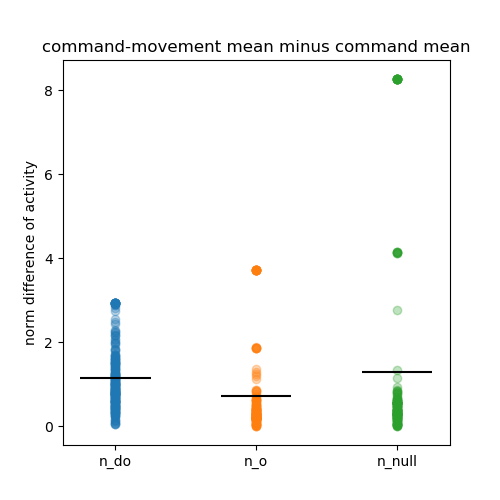

Text(0,0.5,'norm difference of activity')

In [133]:

plt.figure(figsize=(5,5))

min_obs = 1
for i,m in enumerate(model_list):
    sel_m = df_diff['model']==m
    sel_obs = df_diff['num']>=min_obs
    
    
    sel = sel_m&sel_obs
#     sel = sel_m&sel_obs
    diff_i = df_diff.loc[sel, 'diff']
    diff_mean_i = df_diff.loc[sel, 'diff'].mean()
#     num = df_diff.loc[sel, 'num'].mean()
#     print(m, test, num)
    plt.scatter(i*np.ones(len(diff_i)), diff_i, alpha=0.3)
    plt.hlines(diff_mean_i, i-0.25,i+0.25)
    
_=plt.xticks([0,1,2], model_list)
plt.title('command-movement mean minus command mean')
plt.ylabel('norm difference of activity')
    

<IPython.core.display.Javascript object>


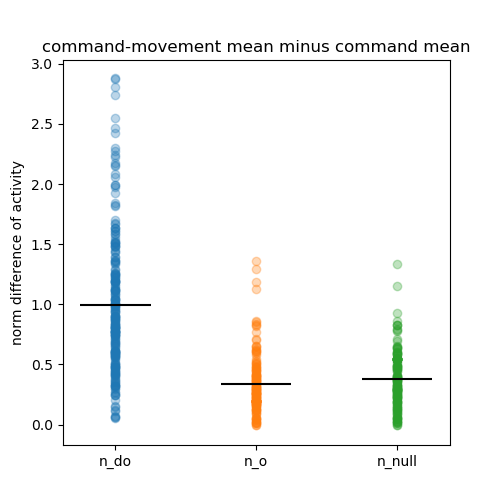

Text(0,0.5,'norm difference of activity')

In [135]:

plt.figure(figsize=(5,5))

min_obs = 1
for i,m in enumerate(model_list):
    sel_m = df_diff['model']==m
    sel_obs = df_diff['num']>=min_obs
    
    
    sel = sel_m&sel_obs
#     sel = sel_m&sel_obs
    diff_i = df_diff.loc[sel, 'diff']
    diff_mean_i = df_diff.loc[sel, 'diff'].mean()
#     num = df_diff.loc[sel, 'num'].mean()
#     print(m, test, num)
    plt.scatter(i*np.ones(len(diff_i)), diff_i, alpha=0.3)
    plt.hlines(diff_mean_i, i-0.25,i+0.25)
    
_=plt.xticks([0,1,2], model_list)
plt.title('command-movement mean minus command mean')
plt.ylabel('norm difference of activity')
    

In [28]:
#Print out mean differences: 
sel_command =False
ba = 1
bm = 0
min_obs = 1

for i,m in enumerate(model_list):
    sel_m = df_diff['model']==m
    sel_obs = df_diff['num']>=min_obs
    sel_ba = df_diff['ba']==ba
    sel_bm = df_diff['bm']==bm
    
    if sel_command:
        sel = sel_m&sel_obs&sel_ba&sel_bm
    else:
        sel = sel_m&sel_obs
    test = df_diff.loc[sel, 'diff'].mean()
    num = df_diff.loc[sel, 'num'].mean()
    print(m, test, num)

('n_do', 0.9896530363512156, 3.5060240963855422)
('n_o', 0.4300245303197417, 5.313609467455621)
('n_null', 0.637915310711509, 5.209302325581396)


In [164]:
save_dir

'D:\\Dropbox\\BMI_co_obs_paper\\data\\vivek\\lqr'

### SAVE RESULTS

In [167]:
#Collect results: 
r = {}
r['An'] = An
r['bn'] = bn
r['n_init'] = n_init
r['kin_var'] = kin_var
r['offset_var'] = offset_var
r['F'] = F
r['Kn'] = Kn
r['A_list'] = A_list
r['A_dic'] = A_dic
r['B'] = B
r['Qfp_s'] = Qfp_s
r['Qfv_s'] = Qfv_s
r['Qp_s'] = Qp_s
r['Qv_s'] = Qv_s
r['R_s'] = R_s
r['Q_f'] = Q_f
r['Q'] = Q
r['R'] = R
r['move_horizon'] = move_horizon
r['model_list'] = model_list
r['input_label'] = input_label
r['state_label'] = state_label
r['num_targets'] = num_targets
r['task_rot_list'] = task_rot_list
r['center'] = center
r['obs_margin'] = obs_margin
r['waypoint_speed'] = waypoint_speed
#------------------------------------------------------------------------------------------------------
r['move_lqr'] = move_lqr #IMPORTANT
#------------------------------------------------------------------------------------------------------
r['df_norm_lqr'] = lqr_df #df_norm_lqr = lqr_df, this df was for plotting norm u to accomplish the movements
#------------------------------------------------------------------------------------------------------
r['df_lqr'] = df_lqr #IMPORTANT
#------------------------------------------------------------------------------------------------------
r['mag_bin'] = mag_bin
r['mag_bin_edges'] = mag_bin_edges
r['mag_bin_c'] = mag_bin_c
r['angle_bin_c'] = angle_bin_c
r['angle_bin'] = angle_bin
r['angle_bin_edges'] = angle_bin_edges
r['angle_center_for_binning'] = angle_center_for_binning
r['num_mag_bins_analyze'] = num_mag_bins_analyze
r['df_mean'] = df_mean
r['df_diff'] = df_diff


In [169]:
save_dir

'D:\\Dropbox\\BMI_co_obs_paper\\data\\vivek\\lqr'

In [168]:
### Save noiseless lqr data: 
save_path = os.path.join(save_dir, 'lqr_noiseless.pkl')
with open(save_path, 'wb') as f: 
    data = pickle.dump(r, f, protocol=pickle.HIGHEST_PROTOCOL)


### Dimensionality Sanity check: 

<IPython.core.display.Javascript object>


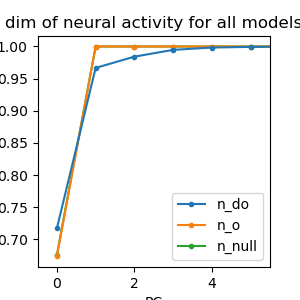

Text(0.5,1,'dim of neural activity for all models')

In [137]:
#what is the dimensionality of neural data in all models: 
move_sel = False
target = 0
task = 0

sel_bin = (df_lqr['bin'] >=1)
plt.figure(figsize=(3,3))
for i,m in enumerate(model_list):
    sel_m = df_lqr['model']==m
    if move_sel:
        sel_target = df_lqr['target']==target
        sel_task = df_lqr['task_rot']==task
        sel = sel_m&sel_target&sel_task
    else:
        sel = sel_m&sel_bin
    n_mat = np.array(df_lqr.loc[sel, n_list])    
    
    n_cov = np.cov(n_mat.T)
    u,s,vh=np.linalg.svd(n_cov) #PCA
    pc_var_exp = np.cumsum(s)/np.sum(s)    
    plt.plot(pc_var_exp, '.-', label=m, zorder=len(model_list)-i)
plt.xlim((-0.5,5.5))
plt.legend()
plt.xlabel('PC')
plt.ylabel('var explained')
plt.title('dim of neural activity for all models')
    
# #sanity check of pca:
# n_cov_hat = np.dot(np.dot(u,np.diag(s)),vh)
# print((n_cov_hat-n_cov).min())

<IPython.core.display.Javascript object>


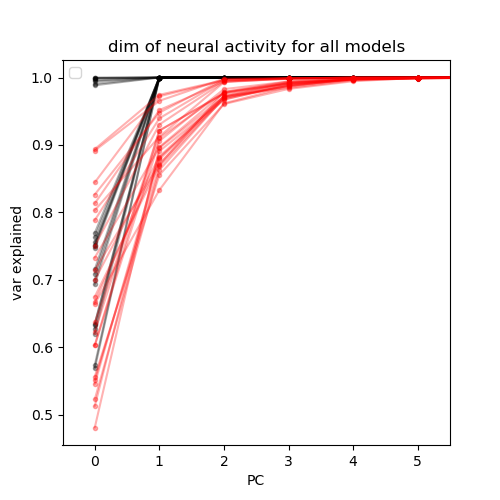

Text(0.5,1,'dim of neural activity for all models')

In [159]:
#dimensionality of activity for different movements
m_color = {'n_do':'r', 'n_null':'k'}

m_plot = ['n_do', 'n_null']
plt.figure(figsize=(5,5))
for target in range(num_targets):
    for task in task_rot_list:
        for i,m in enumerate(m_plot):
            sel_m = df_lqr['model']==m            
            sel_target = df_lqr['target']==target
            sel_task = df_lqr['task_rot']==task
            sel = sel_m&sel_target&sel_task
            
            n_mat = np.array(df_lqr.loc[sel, n_list])    

            n_cov = np.cov(n_mat.T)
            u,s,vh=np.linalg.svd(n_cov) #PCA
            pc_var_exp = np.cumsum(s)/np.sum(s)    
            plt.plot(pc_var_exp, '.-', c=m_color[m], alpha=0.3, zorder=len(model_list)-i)
plt.xlim((-0.5,5.5))
plt.legend()
plt.xlabel('PC')
plt.ylabel('var explained')
plt.title('dim of neural activity for all models')
    
# #sanity check of pca:
# n_cov_hat = np.dot(np.dot(u,np.diag(s)),vh)
# print((n_cov_hat-n_cov).min())

In [160]:
import scipy.linalg

In [162]:
#CHECK ALIGNMENT OF ACTIVITY TO DECODER:
num_pc = 2
for m in model_list:
    sel_m = df_lqr['model']==m
    n_mat = np.array(df_lqr.loc[sel_m, n_list])    
    n_cov = np.cov(n_mat.T)
    u,s,vh=np.linalg.svd(n_cov)
    pc = u #just to be explicit
    ssa = scipy.linalg.subspace_angles(Kn.T, pc[:,:num_pc])
    print(m, 'subspace angles:', ssa*180/np.pi)

('n_do', 'subspace angles:', array([67.95862149, 57.92525012]))
('n_o', 'subspace angles:', array([4.05398267e+00, 2.04390588e-08]))
('n_null', 'subspace angles:', array([3.06347343e-08, 1.27276422e-08]))


In [61]:
np.linalg.matrix_rank(Kn)

2

### Null component during movement

In [ ]:
#Find null component of n_null covariance
#Project n_init into the potent + null dimensions of the decoder, see null alignment with null_cov_dim


<IPython.core.display.Javascript object>


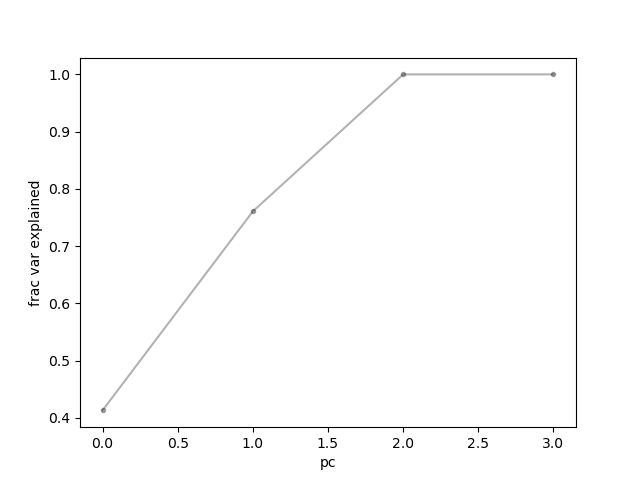

Text(0,0.5,'frac var explained')

In [41]:
#Check PCA 
m = 'n_null'
target = 0
task = 1.1

sel_m = df_lqr['model']==m
sel_target = df_lqr['target']==target
sel_task = df_lqr['task_rot']==task
sel = sel_target&sel_task&sel_m

vx = df_lqr.loc[sel, 'kin_vx']
vy = df_lqr.loc[sel, 'kin_vy']

n_mat = np.array(df_lqr.loc[sel, n_list])    #this movement's neural activity
n_cov = np.cov(n_mat.T)

u,s,vh=np.linalg.svd(n_cov) #PCA
pc_var_exp = np.cumsum(s)/np.sum(s)    
m_color = {'n_do':'r', 'n_null':'k'}
plt.figure()
plt.plot(pc_var_exp[:4], '.-', c=m_color[m], alpha=0.3, zorder=len(model_list)-i)
plt.xlabel('pc')
plt.ylabel('frac var explained')

In [59]:
#Confirm the PC's have 0 angle with decoder
pc = u[:,:3]
d_col = Kn_m[2:4,:].T
ssa = scipy.linalg.subspace_angles(d_col, pc) #these evaluated to 0

In [78]:
#decompose these pc's into the potent and null components of decoder: 
d_col = Kn_m[2:4,:].T #decoder's columns
num_pc = 3

i=0
pc_i = u[:,i].reshape((-1,1))
#project onto decoder: 
_, pc_d_null, _ = bmi_util.proj_null_potent(d_col, pc_i)  #first arg: mat, second arg: data_mat  

if np.linalg.norm(pc_d_null):
    pc_d_null = pc_d_null/np.linalg.norm(pc_d_null)
else:
    print('try a different pc, this one is in the span of the decoder')

In [98]:
#Project this movement's neural activity into the identified basis of:
#d_col, pc_d_null
dx = d_col[:,0]
dy = d_col[:,1]

proj_dx, _, _ = bmi_util.proj_null_potent(dx, n_mat.T) #data_mat: num_dim x num_data_pts
proj_dx = dx.T*proj_dx

proj_dy, _, _ = bmi_util.proj_null_potent(dy, n_mat.T) #data_mat: num_dim x num_data_pts
proj_dy = dy.T*proj_dy

proj_null, _, _ = bmi_util.proj_null_potent(pc_d_null, n_mat.T) #data_mat: num_dim x num_data_pts
proj_null = pc_d_null.T*proj_null

<IPython.core.display.Javascript object>


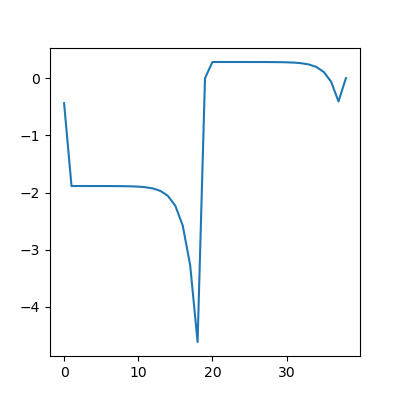

<IPython.core.display.Javascript object>


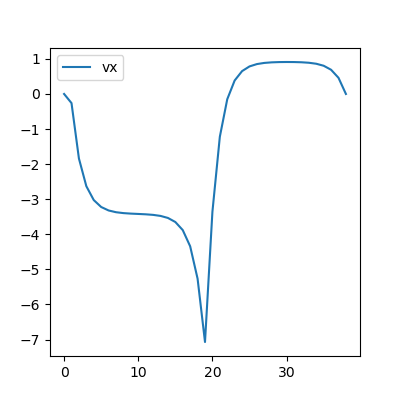

In [109]:
plt.figure(figsize=(4,4))
plt.plot(np.array(proj_dx).squeeze(), label='dx')

plt.figure(figsize=(4,4))
plt.plot(np.array(vx).squeeze(), label='vx')
plt.legend()

<IPython.core.display.Javascript object>


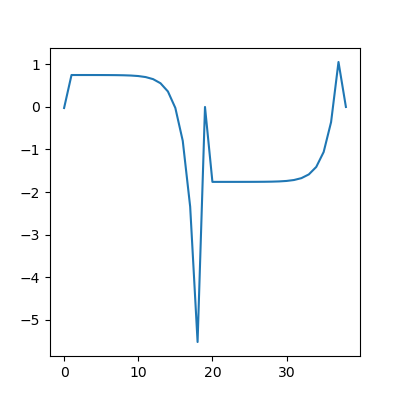

<IPython.core.display.Javascript object>


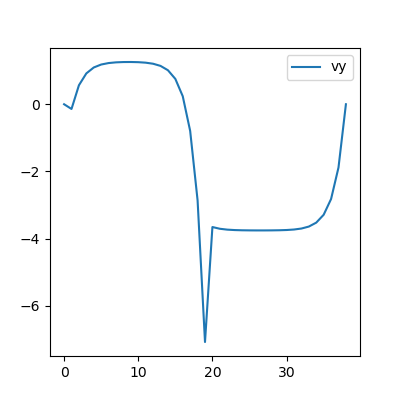

In [111]:
plt.figure(figsize=(4,4))
plt.plot(np.array(proj_dy).squeeze(), label='dy')

plt.figure(figsize=(4,4))
plt.plot(np.array(vy).squeeze(), label='vy')
plt.legend()

<IPython.core.display.Javascript object>


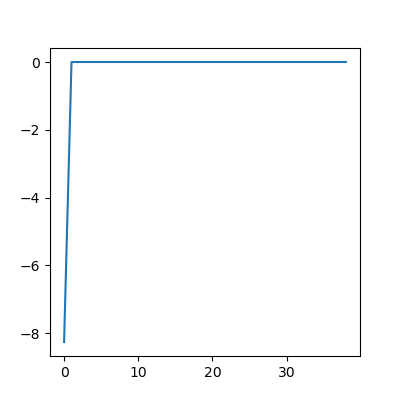

In [115]:
plt.figure(figsize=(4,4))
plt.plot(np.array(proj_null).squeeze(), label='dy')

# plt.figure(figsize=(4,4))
# plt.plot(np.array(vy).squeeze(), label='vy')
# plt.legend()

### SANITY CHECKS about decoder applied to neural activity

In [31]:
target = 2
task = 1.1 
m = 'n_null'
state_da = move_lqr[target,task,m]['state_da'] #n_list, kin_var

#Get neural and kinematic contributions to next kinematic state
n_da = state_da.loc[n_list,:]
Kn_m = np.mat(Kn)
n2k = xr.DataArray(Kn_m*n_da, coords={'v':kin_var+offset_var,'obs':range(n_da.shape[1])}, dims=['v','obs'])

k_da = state_da.loc[kin_var+offset_var,:]
F_m = np.mat(F)
k2k = F_m*k_da
khat = n2k+k2k

i=1
print(khat.loc[:,i])
print(state_da.loc[kin_var+offset_var,i+1])

<xarray.DataArray (v: 5)>
array([-0.105372, -0.195777, -0.741557, -1.789208,  1.      ])
Coordinates:
    obs      int32 1
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'
<xarray.DataArray (v: 5)>
array([-0.105372, -0.195777, -0.741557, -1.789208,  1.      ])
Coordinates:
    obs      int32 2
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'


### SANITY CHECKS ABOUT 0 u norm:

In [182]:
#Double check error and timecourses so that they work...
target = 2
task = 1.1 #1.2
m = 'n_null'

A = move_lqr[target,task,m]['A']
state_da = move_lqr[target,task,m]['state_da']
state_e_da = move_lqr[target,task,m]['state_e_da']
u_da = move_lqr[target,task,m]['u_da']
u_norm = np.linalg.norm(u_da,axis=0)

state_T_list = move_lqr[target,task,m]['state_T_list']
state_T_mat = np.array(state_T_list).squeeze().T
if task==0:
    state_T_mat = state_T_mat.reshape((-1,1))
state_T_da = xr.DataArray(state_T_mat, coords={'v':n_list+kin_var+offset_var, 'seg':range(num_seg)},\
                           dims=['v', 'seg'])


In [179]:
u_norm[37]

0.0

In [176]:
u_norm[18]

0.0

In [180]:
state_da.loc[kin_var,18]

<xarray.DataArray (v: 4)>
array([-1.472796, -6.965928,  2.929173, -5.25696 ])
Coordinates:
    obs      int32 18
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy'

In [170]:
state_da.loc[kin_var,19]

<xarray.DataArray (v: 4)>
array([-0.707106, -7.778174,  7.071067, -7.071068])
Coordinates:
    obs      int32 19
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy'

In [206]:
u_norm[37]

0.0

In [203]:
A = np.mat(A)
x_test = np.mat(state_da.loc[:,37]).T
x_test.shape


(49L, 1L)

In [204]:
A*x_test-np.mat(state_da.loc[:,38]).T

matrix([[ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.

In [195]:
np.mat(state_da.loc[:,19]).T

matrix([[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0

### Simulate one example

In [126]:
#Simulate one example:

target = 7
task = 1.1
m = 'n_null'
# move_lqr[target,task,m]=

A_list = move_lqr[target,task,m]['A_e_list']
B = move_lqr[target,task,m]['B']
K_list = move_lqr[target,task,m]['K_list']
state_init = move_lqr[target,task,m]['state_init']
state_T_list = move_lqr[target,task,m]['state_T_list']
horizon_list = move_lqr[target,task,m]['horizon_list']
num_seg = len(horizon_list)


u_da, state_da, state_e_da, move_len, sim_len = bmi_b.lqr_sim_nk(A_list, B, K_list, state_init, state_T_list, horizon_list, state_label, input_label, num_neurons, hold_req=2, target_r=1.7)

<IPython.core.display.Javascript object>


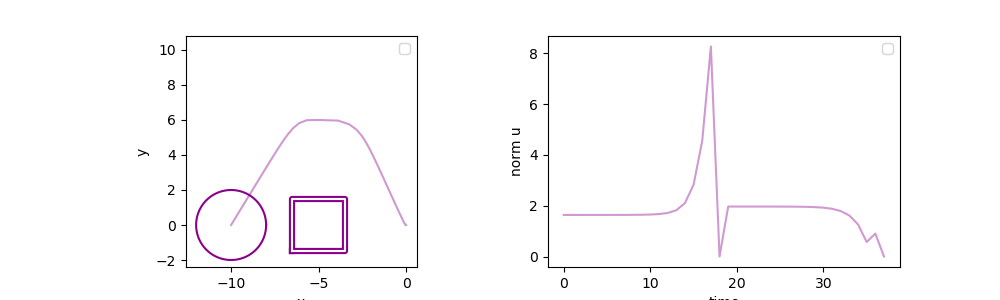

In [127]:
#plot diagnostics: 
state_T_mat = np.array(state_T_list).squeeze().T
if task==0:
    state_T_mat = state_T_mat.reshape((-1,1))
state_T_da = xr.DataArray(state_T_mat, coords={'v':n_list+kin_var+offset_var, 'seg':range(num_seg)},\
                           dims=['v', 'seg'])
#hardcoded:
if task == 0: 
    seg_x = np.array([[0], [horizon_list[0]]])
else:
    seg_x = np.array([[0, horizon_list[0]], [horizon_list[0]-1, sum(horizon_list)-2]])

    
num_sub = 2
plt.figure(figsize=(10,3))
#------------------------------------------------------------------
kin_color = {'x':'k', 'y':'r'}
#TRAJ PLOT
plt.subplot(1,num_sub,1)
x = state_da.loc['kin_px',:]
y = state_da.loc['kin_py',:]        
c = target_color[target]
plt.plot(x,y,'-', alpha=0.4,color=c) # label=k

bmi_util.plot_targets(target_pos[target:target+1,:], target_color[target:target+1], target_r_task[1]*np.ones(1)) 


bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))
plt.axis('square')    
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

#------------------------------------------------------------------
kin_color = {'x':'k', 'y':'r'}
#TRAJ PLOT
plt.subplot(1,num_sub,2)
u_norm = np.linalg.norm(u_da,axis=0)

c = target_color[target]
plt.plot(u_norm,'-', alpha=0.4,color=c) # label=k
# plt.axis('square')    
plt.xlabel('time')
plt.ylabel('norm u')
plt.legend()

<IPython.core.display.Javascript object>


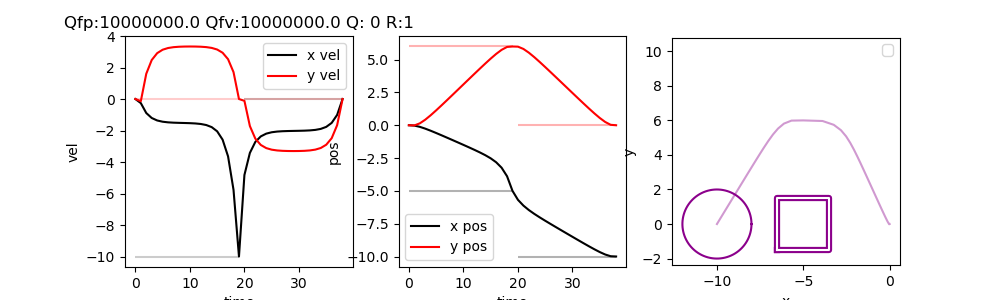

In [128]:
#plot diagnostics: 
state_T_mat = np.array(state_T_list).squeeze().T
if task==0:
    state_T_mat = state_T_mat.reshape((-1,1))
state_T_da = xr.DataArray(state_T_mat, coords={'v':n_list+kin_var+offset_var, 'seg':range(num_seg)},\
                           dims=['v', 'seg'])
#hardcoded:
if task == 0: 
    seg_x = np.array([[0], [horizon_list[0]]])
else:
    seg_x = np.array([[0, horizon_list[0]], [horizon_list[0]-1, sum(horizon_list)-2]])

plt.figure(figsize=(10,3))
#------------------------------------------------------------------
kin_color = {'x':'k', 'y':'r'}
#VELOCITY PLOT
plt.subplot(1,3,1)
x = state_da.loc['kin_vx',:]
y = state_da.loc['kin_vy',:]        
plt.plot(x,'-', alpha=1, label='x vel', color=kin_color['x']) # label=k
plt.plot(y,'-', alpha=1, label='y vel', color=kin_color['y'])


for seg in range(num_seg):
    plt.hlines(state_T_da.loc['kin_vx', seg], seg_x[0,seg], seg_x[1,seg], alpha=0.2, color=kin_color['x']) #label='wp x'
    plt.hlines(state_T_da.loc['kin_vy', seg], seg_x[0,seg], seg_x[1,seg], alpha=0.2, color=kin_color['y'])# label='wp y'

plt.xlabel('time')
plt.ylabel('vel')
plt.legend()
plt.title('Qfp:' + str(Qfp_s) + ' Qfv:' + str(Qfv_s) + ' Q: ' + str(Qp_s) + ' R:' + str(R_s)) 

#------------------------------------------------------------------
kin_color = {'x':'k', 'y':'r'}
#POSITION PLOT
plt.subplot(1,3,2)
x = state_da.loc['kin_px',:]
y = state_da.loc['kin_py',:]        
plt.plot(x,'-', alpha=1, label='x pos', color=kin_color['x']) # label=k
plt.plot(y,'-', alpha=1, label='y pos', color=kin_color['y'])
for seg in range(num_seg):
    plt.hlines(state_T_da.loc['kin_px', seg], seg_x[0,seg], seg_x[1,seg], alpha=0.3, color=kin_color['x']) #label='wp x'
    plt.hlines(state_T_da.loc['kin_py', seg], seg_x[0,seg], seg_x[1,seg], alpha=0.3, color=kin_color['y'])# label='wp y'

plt.xlabel('time')
plt.ylabel('pos')
plt.legend()


#------------------------------------------------------------------
kin_color = {'x':'k', 'y':'r'}
#TRAJ PLOT
plt.subplot(1,3,3)
x = state_da.loc['kin_px',:]
y = state_da.loc['kin_py',:]        
c = target_color[target]
plt.plot(x,y,'-', alpha=0.4,color=c) # label=k

bmi_util.plot_targets(target_pos[target:target+1,:], target_color[target:target+1], target_r_task[1]*np.ones(1)) 


bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))
plt.axis('square')    
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

### Collect all the movement data into a df: 

In [507]:
#start with one movement
target = 2
task = 1.2 #1.2

# target = 7
# task = 1.2
m = 'n_do'
#neural state, cursor state, input, neural "command"

state_da = lqr_sim[target,task,m]['state_da']
u_da = lqr_sim[target,task,m]['u_da']    
state_e_da = lqr_sim[target,task,m]['state_e_da']


In [515]:
#Get neural and kinematic contributions to next kinematic state
n_da = state_da.loc[n_list,:]
Kn_m = np.mat(Kn)
n2k = xr.DataArray(Kn_m*n_da, coords={'v':kin_var+offset_var,'obs':range(n_da.shape[1])}, dims=['v','obs'])

k_da = state_da.loc[kin_var+offset_var,:]
F_m = np.mat(F)
k2k = F_m*k_da
khat = n2k+k2k

i=0
print(khat.loc[:,i])
print(state_da.loc[kin_var+offset_var,i+1])